# MNIST Point Cloud Classification

This task attempts to classify a set of 2D-points in the shape of a number. Using the MNIST dataset, point clouds are generated with a random number of points.

**Note:** the datasets are not included in this repository. Instead, they need to be generated using the [MNIST Point Cloud](https://github.com/DLii-Research/mnist-pointcloud) library.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import settransformer as stf

## Strategy

Grab the appropriate compute device(s).

In [5]:
DEVICE = "gpu:0"
MULTI_GPU = False

In [6]:
if MULTI_GPU:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.OneDeviceStrategy(DEVICE)

## MNIST dataset

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [8]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [9]:
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


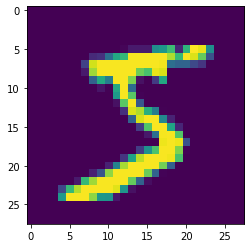

In [10]:
plt.imshow(x_train[0])

## MNIST Point Cloud Generation

In [11]:
class MnistPointCloudGenerator(keras.utils.Sequence):

	def __init__(self, x, y=None, num_points=1000, batch_size=32, threshold=70, shuffle=True, rng=None):
		self.x = x
		self.y = y.astype(np.int32) if y is not None else None
		self.num_points = num_points
		self.batch_size = batch_size if batch_size is not None else len(x)
		self.threshold = threshold
		self.should_shuffle = shuffle
		self.rng = rng if rng is not None else np.random.default_rng()

		self.num_batches = len(self.x) // self.batch_size

		self.init()
		self.shuffle()

	def init(self):
		img_ids, y_pixels, x_pixels = np.nonzero(self.x > self.threshold)
		self.pixels = (np.column_stack((x_pixels, 28 - y_pixels)) - 13.5) / 13.5
		_, self.pixel_counts = np.unique(img_ids, return_counts=True)
		self.pixel_offsets = np.concatenate(([0], np.cumsum(self.pixel_counts)))

	def shuffle(self):
		# Randomize the order of the images
		num_elems = self.num_batches*self.batch_size
		if self.shuffle:
			self.indices = np.reshape(self.rng.permutation(len(self.x))[:num_elems], (-1, self.batch_size))
		else:
			self.indices = np.reshape(np.arange(num_elems), (-1, self.batch_size))

		# Select random pixel indices
		noise = self.rng.uniform(size=(len(self.x), self.num_points))
		self.pixel_indices = (noise * np.reshape(self.pixel_counts, (-1, 1))).astype(np.int64) \
		                   + np.reshape(self.pixel_offsets[:-1], (-1, 1))

		# Generate noise for the pixels
		self.pixel_noise = self.rng.normal(size=(len(self.x), self.num_points, 2), scale=1/13.5/2)

	def __len__(self):
		return self.num_batches

	def __getitem__(self, batch_index):
		indices = self.indices[batch_index]
		batch_x = self.pixels[self.pixel_indices[indices]] + self.pixel_noise[indices]
		if self.y is not None:
			return batch_x, self.y[indices]
		return batch_x

	def on_epoch_end(self):
		self.shuffle()

In [12]:
dataset = MnistPointCloudGenerator(x_train, y_train)

In [13]:
point_clouds, labels = dataset[0] # fetch a batch
print(point_clouds.shape, labels.shape)

(32, 1000, 2) (32,)


The digit is a 1


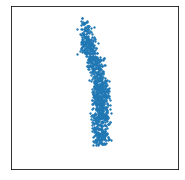

In [14]:
index = 1 # the index of the batch to show

print("The digit is a", labels[index])

plt.figure(figsize=(3, 3))
plt.scatter(*point_clouds[index].T, s=1.7)
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.xticks([])
plt.yticks([])
plt.show()

## Model Architecture

In [15]:
def create_model(
	embed_dim=64,
	num_heads=4,
	num_induce=32,
	stack=2,
	ff_activation="gelu",
	dropout=0.5,
	use_layernorm=False,
	pre_layernorm=False,
	use_keras_mha=False
):
	y = x = keras.layers.Input((None, 2))
	y = keras.layers.Dense(embed_dim)(y)
	for _ in range(stack):
		y = stf.InducedSetAttentionBlock(
			embed_dim=embed_dim,
			num_heads=num_heads,
			num_induce=num_induce,
			ff_activation=ff_activation,
			use_layernorm=use_layernorm,
			pre_layernorm=pre_layernorm,
			use_keras_mha=use_keras_mha)(y)
	
	y = keras.layers.Dropout(dropout)(y)
	y = stf.PoolingByMultiHeadAttention(
		num_seeds=1,
		embed_dim=embed_dim,
		num_heads=1,
		ff_activation=ff_activation,
		use_layernorm=use_layernorm,
		pre_layernorm=pre_layernorm,
		use_keras_mha=use_keras_mha,
		is_final_block=True)(y)
	y = keras.layers.Dropout(dropout)(y)
	y = keras.layers.Dense(10)(y)

	return keras.Model(x, y)

---
## 100-Element Point Clouds

### Dataset

In [16]:
split_index = int(0.2*len(x_train))

train_dataset = MnistPointCloudGenerator(x_train[split_index:], y_train[split_index:], num_points=1000)
val_dataset = MnistPointCloudGenerator(x_train[:split_index], y_train[:split_index], num_points=1000)
test_dataset = MnistPointCloudGenerator(x_test, y_test, num_points=1000)


### Model

In [17]:
with strategy.scope():
    model = create_model(use_keras_mha=False, dropout=0.0, stack=2, use_layernorm=True)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )
    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 2)]         0         
                                                                 
 dense (Dense)               (None, None, 64)          192       
                                                                 
 induced_set_attention_block  (None, None, 64)         35328     
  (InducedSetAttentionBlock)                                     
                                                                 
 induced_set_attention_block  (None, None, 64)         35328     
 _1 (InducedSetAttentionBloc                                     
 k)                                                              
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                             

### Training

In [18]:
with strategy.scope():
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)
    # history = model.fit(x_train, y_train, validation_split=0.2, epochs=20)

2022-06-09 03:57:15.570985: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1497"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      

Epoch 1/20
  12/1500 [..............................] - ETA: 24s - loss: 2.5184 - sparse_categorical_accuracy: 0.1079

2022-06-09 03:57:18.517907: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1499/1500 [============================>.] - ETA: 0s - loss: 0.8011 - sparse_categorical_accuracy: 0.1192

2022-06-09 03:57:41.610721: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_14447"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:15"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
    

1500/1500 [==============================] - 30s 18ms/step - loss: 0.8009 - sparse_categorical_accuracy: 0.1192 - val_loss: 0.2443 - val_sparse_categorical_accuracy: 0.1259
Epoch 2/20
 581/1500 [==========>...................] - ETA: 14s - loss: 0.2485 - sparse_categorical_accuracy: 0.1261

KeyboardInterrupt: 

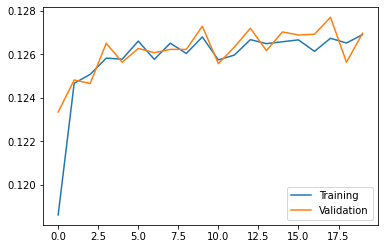

In [ ]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.legend(["Training", "Validation"])
plt.show()

### Evaluation

In [22]:
with strategy.scope():
    model.evaluate(test_dataset)

 20/312 [>.............................] - ETA: 1s - loss: 0.1750 - sparse_categorical_accuracy: 0.1297

2022-06-09 02:54:56.135295: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_163540"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:295"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
  

312/312 [==============================] - 2s 5ms/step - loss: 0.1528 - sparse_categorical_accuracy: 0.1270
